## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [155]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

# with open('sonnets.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# TEXT_START = 45
# TEXT_END = -368
# text = text[TEXT_START : TEXT_END]
# assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# # Join all the strings into one and lowercase it
# # Put result into variable text.

# # Your great code here
# text = ''.join(text).lower()

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

### Data loading: "Евгений Онегин"


In [156]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2023-12-12 20:06:54--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256,37K  --.-KB/s    in 0,06s   

2023-12-12 20:06:55 (4,11 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [157]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

In [ ]:
# import re
# text = re.sub("[i|v|x|c|]", '', text)
# text = re.sub("\n+", '\n', text)
# text[:500]

Put all the characters, that you've seen in the text, into variable `tokens`.

In [158]:
'''
Создадим множество всевозможных символов, которые встречаются в тексте.
Таким образом, в этом контейнере мы получим только уникальные символы.
'''
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [159]:
import numpy as np
'''
Занумеруем встречающиеся символы и создадим 2 слваря взаимно-обратного отображения.
Определенному символу соответствует определенное число,
Определенному числу соответствует определенный символ.
'''

# dict <index>:<char>
# Your great code here
tokens_list = list(tokens)
token_to_idx = {c:i for i, c in enumerate(tokens_list)}

# dict <char>:<index>
# Your great code here
idx_to_token = {i:c for i, c in enumerate(tokens_list)}

num_of_tokens = len(tokens_list)

# с помощью отображения закодируем текст поэмы и представим его в виде массива чисел, 
# в этом представлении с ним уже может работать компуктер
encoded = np.array([token_to_idx[c] for c in text], dtype=np.int32)

In [160]:
'''
Напишем функцию, которая выбирает батчи последовательностей из текста.

Here I tried to implement my own batch generation function. It worksm but worse
than DataLoader from torch. Actually, I'm still not good in it.
'''
def get_batches(arr, n_seqs, n_steps):
    '''Создаем генератор, который возвращает пакеты размером
       n_seqs x n_steps из массива arr.
       
       Аргументы
       ---------
       arr: Массив, из которого получаем пакеты
       n_seqs: Batch size, количество последовательностей в пакете
       n_steps: Sequence length, сколько "шагов" делаем в пакете
    '''
    # Считаем количество символов на пакет и количество пакетов, которое можем сформировать
    characters_per_batch = n_seqs * n_steps
    n_batches = len(arr)//characters_per_batch
    
    # Сохраняем в массиве только символы, которые позволяют сформировать целое число пакетов
    arr = arr[:n_batches * characters_per_batch]
    
    # Делаем reshape 1D -> 2D, используя n_seqs как число строк, как на картинке
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # пакет данных, который будет подаваться на вход сети
        x = arr[:, n:n+n_steps]
        # целевой пакет, с которым будем сравнивать предсказание, получаем сдвиганием "x" на один символ вперед
        y = np.zeros_like(x)
        y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
        yield x, y

In [161]:
from torch.utils.data import DataLoader
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, sequence_length=10):
        self.sequence_length = sequence_length
        self.text = [token_to_idx[c] for c in text]
    def __len__(self):
        return len(self.text) - self.sequence_length
    def __getitem__(self, index):
        return (
            torch.tensor(self.text[index:index+self.sequence_length]),
            torch.tensor(self.text[index+1:index+self.sequence_length+1]),
        )

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [162]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
'''
Напишем класс сверточной нейронной сети.
'''

# Your code here
class CharRNNCell(nn.Module):
    '''
    В конструктор передаем мощность алфавита (количество токенов),
    размер вектора, который будет представлять наш контекст -- embedding_size,
    длинну последовательности букв, которая будет обрабатываться на каждом этапе рекурсии (по умолчанию -- последовательность из 10 букв)
    '''
    def __init__(self, num_tokens=num_of_tokens, embedding_size=70, sequence_length=10):
        super(self.__class__,self).__init__()
        self.sequence_length = sequence_length
        
        self.embedding = nn.Embedding(num_tokens, embedding_size) # преобразование, которое переводит слово в вектор контекста
        self.rnn_update = nn.Linear(embedding_size + sequence_length, sequence_length) # линейное преобразование, которое применяется к конкатенации новго слова и прошлого контекста
        self.rnn_to_logits = nn.Linear(sequence_length, num_tokens) # трансляция полученного вектора в вектор логитов
        
    def forward(self, x, h_prev):
        '''
        Напишем функцию прямой прогонки
        '''
        x_emb = self.embedding(x) # на вход рекурентного блока мы получаем новое слово x и предыдущий вектор контекста; новое слово мы должны превратить в вектор
        x_and_h = torch.cat([x_emb, h_prev], dim=1) # конкотенируем полученный вектор и вектор контекста
        h_next = self.rnn_update(x_and_h) # применяем линейное преобразование
        h_next = torch.tanh(h_next) # применяем нелинейное преобразование
        logits = self.rnn_to_logits(h_next) # перегоняем вектор контекста в вектор логитов
        return F.log_softmax(logits, -1), h_next # возвращаем "вероятности" логитов и новый вектр контекста
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.sequence_length, requires_grad=True)

In [163]:
'''
Раньше батч представлял собой набор векторов и, таким образом, получалась матрица чисел.
Сейчас батч -- есть набор последовательностей, причем обучение на одной последовательности состоит в том,
что для очередной буквы в последовательности мы пытаемся предсказать следующую.
Таким оборазом, каждую последовательность в батче необходимо обрабатывать отдельно.

Напишем функцию для обучения на одном батче
'''
def rnn_loop(rnn_model, batch):
    batch_size, max_length = np.shape(batch)

    # инициализируем начальное состояние
    hid_state = rnn_model.initial_state(batch_size)
    logprobs = []

    for x_t in batch.T:
        logp_next, hid_state = rnn_model(torch.tensor(x_t), torch.tensor(hid_state))
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [165]:
# Your plot code here

# обучим модель
rnn = CharRNNCell()
optimizer = optim.Adam(rnn.parameters(), lr=0.001)
criterion = nn.NLLLoss()

n_epoch = 20
sequence_length = 15
batch_size = 128
history = []

dataset = Dataset(sequence_length=sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size)

rnn.train()
for epoch in range(n_epoch):
    h = rnn.initial_state(sequence_length)
    #! Previous it used a custom batch generator, but now we use DataLoader
    # for batch_obj, batch_labels in get_batches(encoded, batch_size, sequence_length):
    for batch_obj, batch_labels in dataloader:
        # обучаемся на батче
        predictions_logp = rnn_loop(rnn, batch_obj)
        actual_next_tokens = torch.LongTensor(batch_labels)
        # сравниваем предсказанные символы с метками обучения
        loss = criterion(
          predictions_logp.contiguous().view(-1, len(tokens)),
          actual_next_tokens.contiguous().view(-1)
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    history.append(loss.item())

/tmp/ipykernel_3497509/1607109532.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logp_next, hid_state = rnn_model(torch.tensor(x_t), torch.tensor(hid_state))


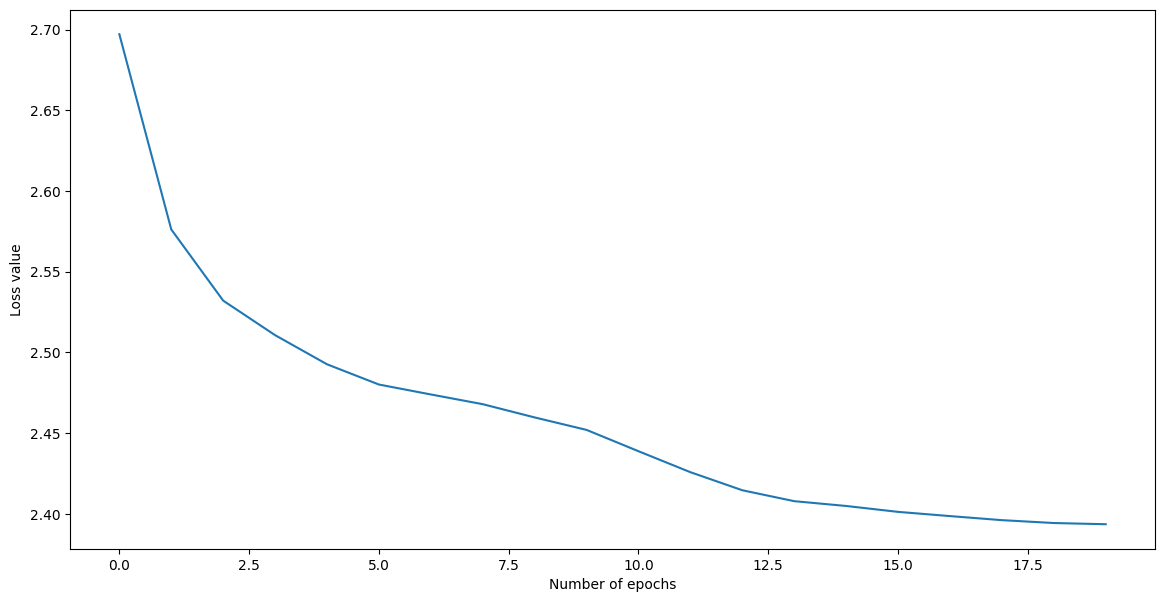

In [166]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')

plt.plot(history)
plt.show()

In [167]:
def generate_sample(char_rnn, seed_phrase='мой дядя', max_length=100, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
 
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [170]:
# An example of generated text.
print(generate_sample(rnn, seed_phrase='так думал'))

так думал, реперны течнед,
– мит, кова бывмокиг вли тови стоть элеtteparлгея ей цгоюдтаю тенниги,,
у


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [171]:
# Your beautiful code here
class LSTM(nn.Module):
    def __init__(self, num_of_tokens=num_of_tokens, embedding_size=128, num_layers=1):
        super(self.__class__, self).__init__()
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_of_tokens, self.embedding_size)
        self.lstm = nn.LSTM(
            input_size=self.embedding_size,
            hidden_size=self.embedding_size,
            num_layers=self.num_layers # number of recurent layers (by default 1; it need to build deep recurent networks)
        )
        self.rnn_to_logit = nn.Linear(self.embedding_size, num_of_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        output, h_next = self.lstm(x_emb, h_prev)
        logits = self.rnn_to_logit(output)
        return logits, h_next
    
    def initial_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.embedding_size),
                torch.zeros(self.num_layers, sequence_length, self.embedding_size))

In [172]:
model = LSTM()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = []

dataset = Dataset(sequence_length=sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size)

model.train()
for epoch in range(n_epoch):
    (h, c) = model.initial_state(sequence_length)
    #! Previous it used a custom batch generator, but now we use DataLoader
    # for batch_obj, batch_labels in get_batches(encoded, batch_size, sequence_length):
    for batch_obj, batch_labels in dataloader:
        optimizer.zero_grad()
        y_pred, (h, c) = model(torch.LongTensor(batch_obj), (h, c))
        loss = criterion(y_pred.transpose(1, 2), torch.LongTensor(batch_labels))
        h.detach_()
        c.detach_()
        loss.backward()
        optimizer.step()
    history.append(loss.item())

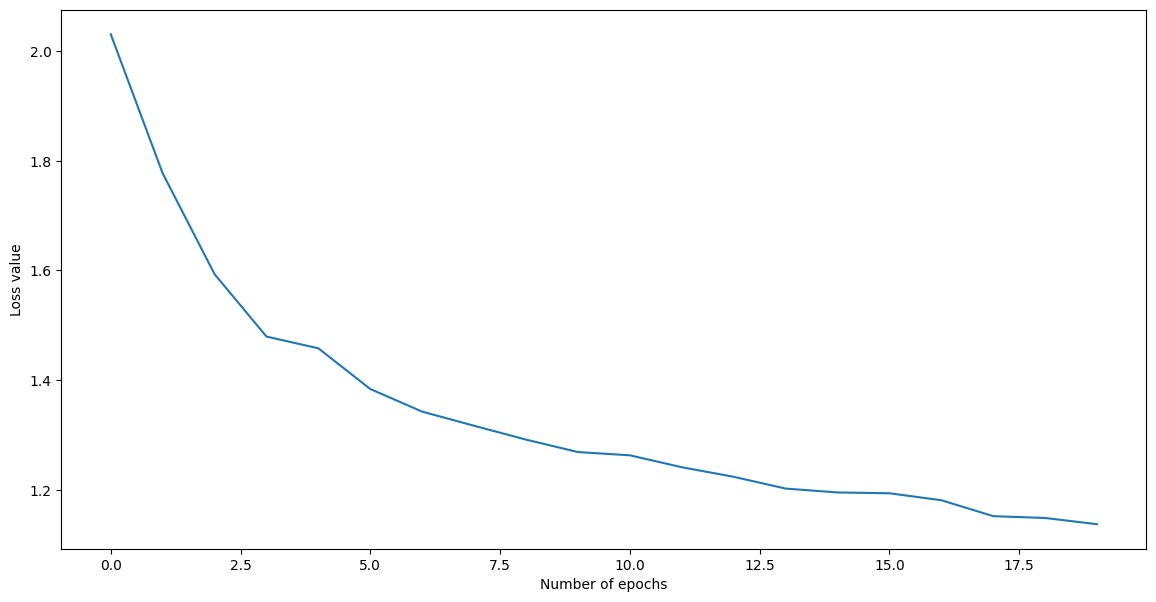

In [173]:
plt.figure(figsize=(14,7))
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')

plt.plot(history)
plt.show()

In [174]:
def generate_sample(model, seed_phrase=' ', max_length=100, temperature=0.2):
    model.eval()
    h, c = model.initial_state(len(seed_phrase))
    for i in range(0, max_length):
        x = torch.tensor([[token_to_idx[c] for c in seed_phrase[i:]]])
        y_pred, (h, c) = model(x, (h, c))
        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits / temperature, dim=0).detach().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        seed_phrase = seed_phrase + idx_to_token[char_index]
    return seed_phrase

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [176]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temperatures:
    print(generate_sample(model, seed_phrase='мой дядя', temperature=temp, max_length=200))
    print()
    print()

мой дядянь,
весна в молча простой он.



xliii

и на то бы не простих сосед,
и в том страсти в том своей.



xlii

как ваше в том страсти с ним
старинный был он в сердцем
с так было в сердце мой она
сидит в м


мой дядянь,
весных души, мой постеле том,
как будто наш в сердце в том
и в садает об нему вот
и сладость он в сердцем она
с блистал молча примечала
с бестрешать на страсть и нет,
и в том свои молча след.



x


мой дядя,
верной долго постарины,
к ней как нашей мое в том,
что милый, простих преданский взор,
было в умел таня молодой.



xxxvii

онегин свете поранец,
быть может был отдых городе
в нем мог наших устает о


мой дядя:
в
свою чудном важно девиц.
в тих я судьбу котая совстви
и детей во вродыхает,
был в генеских поклонем, целых,
я совсем лежели далых бог
и вошь не забытный женав,
не ускажь, наконецец радных,
труд то


мой дядя хобу?
)от пилые, ей, руси,
сагрвит ей! а язы сердов.
уж иль твреят и бытьмящим
вур, маре: тми умой?
фcукбли, счела оживаться,;
и я б?»
– – юныv что

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here
path_to_save = '/home/pavel/workdir/remote_work/ml-course-home-tasks/homeworks/lab02_deep_learning'
file_to_save = 'model'
torch.save(model.state_dict(), path_to_save + '/' + file_to_save)

In [ ]:
copy_model = LSTM()
copy_model.load_state_dict(torch.load(path_to_save + '/' + file_to_save))
print(generate_sample(copy_model, temperature=0.5, seed_phrase='как рано мог уж он тревожить', max_length=200))

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)